# Study Course Deep Learning
# Task: MC1 - Image Classification

**Author:** Simon Staehli / 5Da

## Tasks

- Anpassung der Modellkomplexität
- Fitten des Datensatzes mit einer gängigen Netzwerkstruktur
- Verwendung anderer OPtimizer: Adam, SGD, ...
- Verwendung von Regularisierung L2, Batchnorm
- Analysen basierend auf verschieden komplexen Modellen (Regularisierung aufzeigen mit Kostenfunktion)
- Transferlearning mit einem vortrainierten Netz: VGG, ResNet

## MC-Goals

https://gitlab.fhnw.ch/deep_learning/sgds/trainingscenter/-/blob/master/mini-challenges/SGDS_DEL_MC1.pdf

## Use-Case

Für diese Mini-Challenge habe ich ein eigenen Datensatz zusammengestellt aus diversen Bilder, welche mit Klassen gelabelt sind.
Der Datensatz besteht aus ca. 29'000 Bilder und 28 Labels. 1000 Bilder pro Label.

In [17]:
import sys
import os
import shutil
import numpy as np
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import random
import seaborn as sns
import pandas as pd
import pickle

from multiprocess import Pool
from program.helper import *
from program.mlp_optimization import *
from program.utility import *

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import KFold

## Vorbereitung des Datensatzes

### Generierung Datensatz für Train-Test-Split

Nun werde ich nachfolgend basierend auf meinen gesammelten Daten eine neue Ordnerstruktur generieren, ein Train-Test Split Erstellen und als Dictionary speichern und das Dictionary vorbereiten für das Kopieren der Bilder in einen Neuen Ordner mit Multiprocessing.

In [18]:
curr_img_path = "images"
new_img_path = "data"
train_size = 0.9

In [19]:
process_image_folder = False

if process_image_folder:
    image_splits = generate_train_test_from_folder(
        img_path=curr_img_path, train_size=train_size
    )
    create_train_test_folder(split_dict=image_splits, fp_new_folder=new_img_path)
    fp_from_to = prepare_img_splits(split_dict=image_splits, new_fp=new_img_path)

In [20]:
# Remove corrupted images
if process_image_folder:
    drop_corrupted_images(image_paths=fp_from_to)

Hier kopiere ich alle Files in den neuen Ordner mit Multiprocessing

In [21]:
if process_image_folder:
    copy_all_files(fp_from_to=fp_from_to, n_proc=4)

----------

# PyTorch: CNN

## DataLoader

Zuerst muss ich einige Preprozessierungsschritte bei der Bearbeitung der Bilder vornehmen. Dafür verwende ich die Klasse `Compose` von torchvision. Torchvision beinhaltet auch Schritte, die auf Bilder angewendet werden können. Für meine Bilder verwende ich: `Resize, CenterCrop, ToTensor` in dieser Reihenfolge.

In [22]:
# Define a Composal of image transformation used for image load
transform_images = Compose([Resize((128, 128)), 
                            ToTensor()])

In [23]:
train_data = ImageFolder("data/train", transform=transform_images)
test_data = ImageFolder("data/test", transform=transform_images)

In [24]:
label_translator = dict(
    zip([*train_data.class_to_idx.values()], [*train_data.class_to_idx.keys()])
)
label_translator

{0: 'abstract',
 1: 'aerial',
 2: 'animals',
 3: 'black and white',
 4: 'celebrities',
 5: 'city and architecture',
 6: 'commercial',
 7: 'concert',
 8: 'family',
 9: 'fashion',
 10: 'film',
 11: 'fine art',
 12: 'food',
 13: 'journalism',
 14: 'landscapes',
 15: 'macro',
 16: 'nature',
 17: 'night',
 18: 'people',
 19: 'performing arts',
 20: 'sport',
 21: 'still life',
 22: 'street',
 23: 'transportation',
 24: 'travel',
 25: 'underwater',
 26: 'urban exploration',
 27: 'wedding'}

In [25]:
with open('./program/label_translator.pkl', 'wb') as pkl_file:
    pickle.dump(label_translator, pkl_file)

In [26]:
# Test size
train_size = len(train_data.targets) / (
    len(train_data.targets) + len(test_data.targets)
)
print("Train Size in Folder: ", train_size)

Train Size in Folder:  0.8995574437953621


In [27]:
dataloader_train = DataLoader(train_data, batch_size=128, shuffle=True, 
                              num_workers=24, pin_memory=True)
dataloader_test = DataLoader(test_data, batch_size=128, shuffle=True, 
                             num_workers=24, pin_memory=True)

In [28]:
# Plot some images
images, labels = next(iter(dataloader_train))

In [29]:
def plot_images_from_loader(
    images_from_loader: list, labels: list, amount: int, **args
):
    """"""
    plot_idx = np.random.permutation(np.arange(0, len(images_from_loader)))[:amount]
    plot_images = images_from_loader[plot_idx]
    plot_images = [to_pil_image(img) for img in plot_images]
    plot_images_labels = labels[plot_idx]

    ncol = args.get("ncol", None) if args.get("ncol", None) else 5
    nrow = int(amount / ncol) + 1
    fig = plt.subplots(figsize=(20, 4 * nrow))
    for i, img_label in enumerate(zip(plot_images, plot_images_labels)):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(img_label[0])
        plt.title(
            f"Label: {img_label[1].tolist()} / {label_translator[img_label[1].tolist()]}"
        )
    plt.show()

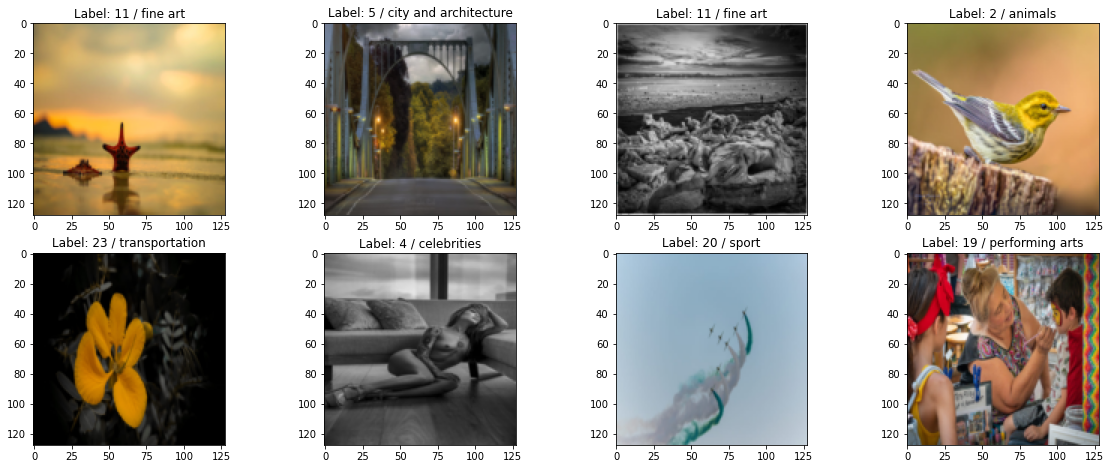

In [30]:
plot_images_from_loader(images_from_loader=images, labels=labels, amount=8, ncol=4)